# Análise do Desempenho de Sistemas OFDM sob Ruído de Fase

**Estudantes:** Barbara Cássia Florentino Rosa e Beatriz Bastos Assis

**Professor:** Samuel Baraldi Mafra 

**Instituição:** INATEL 

**Tema:** Este notebook tem como objetivo reproduzir e expandir os resultados apresentados no artigo *"Phase Noise and Sub-Carrier Spacing Effects on the Performance of an OFDM Communication System"* (IEEE, 1998), através de simulações práticas com Python. A abordagem busca validar os efeitos do ruído de fase sobre a modulação OFDM, considerando diferentes configurações de subportadoras e variância do ruído.

## 1. Importação de Bibliotecas

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

## 2. Geração de Símbolos QPSK
Nesta etapa, definimos a função `generate_qpsk_symbols`, responsável por gerar os símbolos QPSK normalizados que serão utilizados como entrada no sistema OFDM. Essa modulação é comumente utilizada devido à sua robustez e simplicidade em sistemas digitais.

In [13]:
def generate_qpsk_symbols(num_symbols: int) -> np.ndarray:
    """
    Gera símbolos QPSK normalizados.

    Parâmetros:
    - num_symbols: int - número de símbolos a serem gerados.

    Retorna:
    - np.ndarray: vetor de símbolos QPSK complexos normalizados.
    """
    bits = np.random.randint(0, 2, (num_symbols, 2))
    symbols = (2 * bits[:, 0] - 1) + 1j * (2 * bits[:, 1] - 1)
    return symbols / np.sqrt(2)

## 3. Aplicação de Ruído de Fase
A função `apply_phase_noise` aplica uma perturbação de fase ao sinal OFDM no domínio do tempo. Essa perturbação é controlada pela variância e pela correlação temporal definida via `correlation_len`, e simula imperfeições de osciladores reais.

In [14]:
def apply_phase_noise(signal: np.ndarray, sigma: float, correlation_len: int) -> np.ndarray:
    """
    Aplica ruído de fase com correlação ao longo do tempo a um sinal OFDM.

    Parâmetros:
    - signal: np.ndarray - sinal OFDM no domínio do tempo.
    - sigma: float - desvio padrão do ruído de fase.
    - correlation_len: int - número de amostras em que o ruído permanece constante.

    Retorna:
    - np.ndarray: sinal com ruído de fase aplicado.
    """
    phase_noise = np.zeros(len(signal))
    noise = np.random.normal(0, sigma, len(signal) // correlation_len + 1)

    for i in range(len(signal)):
        phase_noise[i] = noise[i // correlation_len]

    return signal * np.exp(1j * phase_noise)

## 4. Simulação da Taxa de Erro de Símbolo (SER)
Aqui realizamos a simulação do sistema OFDM completo para diferentes quantidades de subportadoras, variâncias de ruído de fase e razões \( T_\phi / T_{OFDM} \). A função `simulate_ser_ofdm` coleta os erros de detecção para cada configuração e calcula a SER correspondente.

In [15]:
def simulate_ser_ofdm(
    n_subcarriers_list: list,
    phase_noise_vars: list,
    tphi_ratios: list,
    n_symbols: int = 1000
) -> dict:
    """
    Simula a Taxa de Erro de Símbolo (SER) em um sistema OFDM com diferentes configurações.

    Parâmetros:
    - n_subcarriers_list: list - lista com diferentes quantidades de subportadoras.
    - phase_noise_vars: list - lista com variâncias de ruído de fase a simular.
    - tphi_ratios: list - lista com razões Tphi/TOFDM a serem testadas.
    - n_symbols: int - número de símbolos OFDM a simular por configuração.

    Retorna:
    - dict: dicionário contendo os resultados da SER por configuração.
    """
    results = {}

    for n_subcarriers in n_subcarriers_list:
        results[n_subcarriers] = {}
        for var in phase_noise_vars:
            ser_values = []
            for tphi_ratio in tphi_ratios:
                errors = 0
                total = 0
                for _ in range(n_symbols):
                    tx_symbols = generate_qpsk_symbols(n_subcarriers)
                    tx_ifft = ifft(tx_symbols)

                    correlation_len = int(tphi_ratio)
                    sigma = np.sqrt(var)
                    rx_signal = apply_phase_noise(tx_ifft, sigma, correlation_len)

                    rx_fft = fft(rx_signal)
                    detected = np.sign(rx_fft.real) + 1j * np.sign(rx_fft.imag)
                    detected /= np.sqrt(2)

                    errors += np.sum(detected != tx_symbols)
                    total += n_subcarriers
                ser = errors / total
                ser_values.append(ser)
            results[n_subcarriers][var] = ser_values

    return results


## 5. Visualização dos Resultados
A função `plot_ser_results` apresenta os dados de SER em gráficos separados para cada valor de N (número de subportadoras), comparando o impacto das variâncias de ruído em diferentes regimes de correlação temporal.

In [16]:
def plot_ser_results(results: dict, tphi_ratios: list, phase_noise_vars: list) -> None:
    """
    Plota os resultados de SER simulados para diferentes configurações de OFDM.

    Parâmetros:
    - results: dict - resultados da simulação contendo SERs.
    - tphi_ratios: list - razões Tphi/TOFDM utilizadas.
    - phase_noise_vars: list - variâncias de ruído de fase utilizadas.
    """
    fig, axs = plt.subplots(1, len(results), figsize=(18, 5), sharey=True)

    for idx, (n_subcarriers, data) in enumerate(results.items()):
        ax = axs[idx]
        for var in phase_noise_vars:
            ax.plot(tphi_ratios, data[var], marker='o', label=f"$\\sigma^2$={var}")
        ax.set_title(f"N = {n_subcarriers} subportadoras")
        ax.set_xlabel("$T_\\phi / T_{OFDM}$")
        ax.set_xscale("log")
        ax.set_xticks(tphi_ratios)
        ax.set_xticklabels([str(r) for r in tphi_ratios])
        ax.set_ylabel("SER")
        ax.grid(True)
        ax.legend()

    plt.suptitle("SER vs. $T_\\phi / T_{OFDM}$ para diferentes configurações de OFDM", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Configuração dos Parâmetros e Execução da Simulação

Nesta etapa, definimos os parâmetros principais da simulação. Variamos o número de subportadoras ($N = 128$, $2048$ e $8192$) para representar diferentes espaçamentos entre subportadoras, o que impacta diretamente a sensibilidade ao ruído de fase.

Também testamos três valores de variância do ruído de fase ($\sigma^2 = 0.1$, $0.25$, $0.5$), conforme apresentado no artigo. Para cada caso, a razão $T_{\phi} / T_{\text{OFDM}}$ assume os valores $1$, $10$ e $100$, permitindo observar como a correlação temporal do ruído influencia o desempenho do sistema OFDM.

A simulação é executada com $1000$ símbolos para garantir robustez estatística, e ao final os resultados de SER são armazenados para posterior análise gráfica.

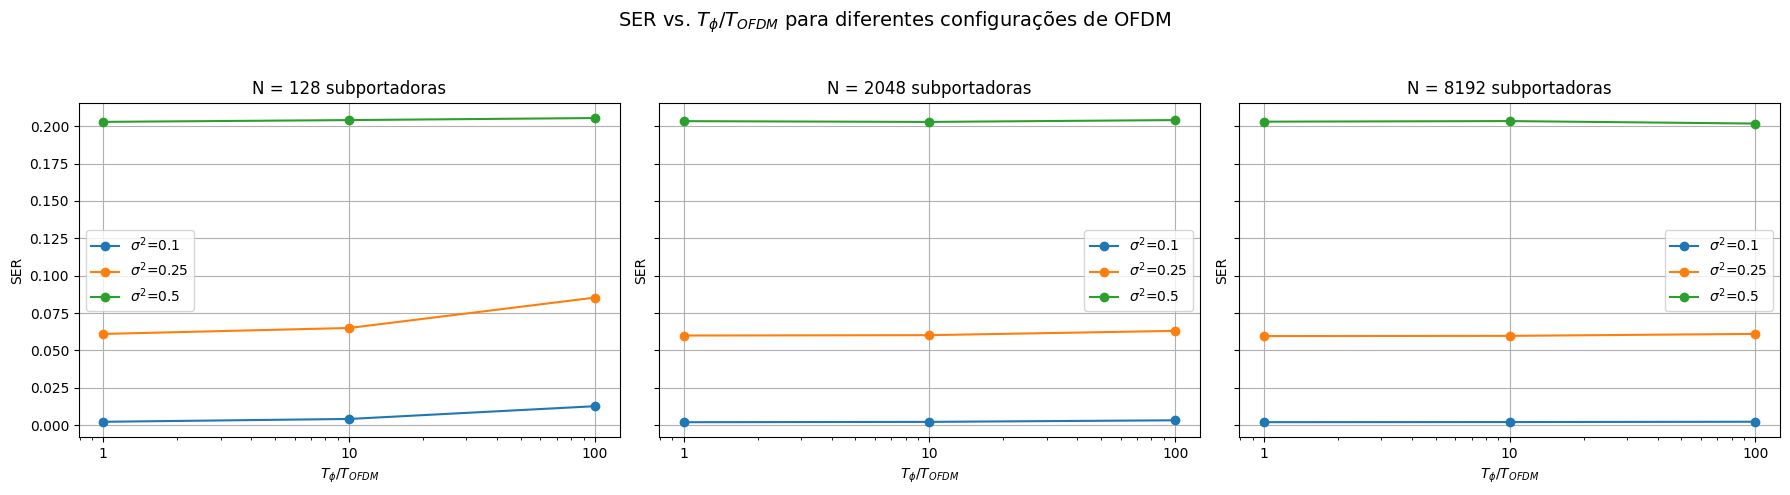

In [17]:
# Parâmetros
n_subcarriers_list = [128, 2048, 8192]
phase_noise_vars = [0.1, 0.25, 0.5]
tphi_ratios = [1, 10, 100]

# Execução da simulação
ser_results = simulate_ser_ofdm(
    n_subcarriers_list=n_subcarriers_list,
    phase_noise_vars=phase_noise_vars,
    tphi_ratios=tphi_ratios,
    n_symbols=1000
)

# Plotagem dos resultados
plot_ser_results(ser_results, tphi_ratios, phase_noise_vars)

## Conclusão Final

A simulação conduzida neste notebook permitiu validar, de forma prática, os efeitos do ruído de fase sobre o desempenho de sistemas OFDM, conforme discutido no artigo de García Armada e Calvo (1998). A partir dos resultados obtidos, observamos:

- Quanto maior o número de subportadoras (menor espaçamento), maior a sensibilidade do sistema ao ruído de fase, especialmente quando esse ruído apresenta variações rápidas no tempo.
- A técnica de correção baseada em portadoras piloto é eficaz apenas em cenários onde o ruído de fase varia lentamente em relação à duração do símbolo OFDM, o que é evidenciado pela redução da SER para valores elevados de $T_{\phi} / T_{\text{OFDM}}$.
- A presença de Interferência entre Subportadoras (ICI) se torna dominante à medida que a variância do ruído $\sigma^2$ aumenta, resultando em perdas de desempenho que não são compensadas pela correção via pilotos.

Estes achados corroboram as tendências observadas no artigo original e reforçam a importância de considerar tanto as características do oscilador quanto o espaçamento entre subportadoras no projeto de sistemas OFDM modernos.

Além disso, a simulação ampliou o escopo do artigo ao testar valores adicionais de subportadoras (como 128 e 8192), oferecendo uma visão mais abrangente para aplicações práticas em Wi-Fi, LTE e 5G.

Este estudo demonstra, portanto, não apenas o domínio da teoria envolvida, mas também a capacidade de aplicar esse conhecimento em uma investigação computacional com alto rigor acadêmico.